In [1]:
import sys
from pathlib import Path

# Add the path to the utils folder to sys.path
utils_path = Path('../python').resolve()
print(utils_path)
sys.path.append(str(utils_path))

from pathlib import Path
from rasterio.crs import CRS
from crop_utils import (crop_image_by_coordinates, 
                        crop_image_by_geojson_shp, 
                        reproject_geotiff)
from edit_path_utils import (edit_paths)

import rasterio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from process_utils import (preprocess_data,
                           superpixel_segmentation,
                            tv_denoise, 
                            preprocess_for_merge)
from rio_utils import (reproject_arr_to_match_profile)

/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/Alpha_Code/wildfire_new/uavsar-main/python


In [2]:
# Opens a GeoTIFF and loads the backscatter values and profile
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
        profile = ds.profile
    return band, profile

In [3]:
def inc_filter(img):
    img_deg = np.rad2deg(img)
    mask = (img_deg < 25) | (img_deg > 65)
    img_deg[mask] = 999
    return img_deg

In [4]:
def denoise(data, weight):
    mask = np.isnan(data)
    data[mask] = 9999
    data_tv = tv_denoise(data, weight)
    data_tv[mask] = np.nan

    return data_tv

In [5]:
def weighted_inc_merge(img_0, img_1, inc_0, inc_1):
    
    valid_pixel_0 = ~np.isnan(img_0) & (inc_0 >= 25) & (inc_0 <= 65)
    valid_pixel_1 = ~np.isnan(img_1) & (inc_1 >= 25) & (inc_1 <= 65)
    invalid_pixel_0 = np.isnan(img_0) | (inc_0 < 25) | (inc_0 > 65)
    invalid_pixel_1 = np.isnan(img_1) | (inc_1 < 25) | (inc_1 > 65)

    w0 = inc_0/ (inc_0 + inc_1)
    w1 = inc_1 / (inc_0 + inc_1)
    img_merged = np.empty_like(img_0)
    img_merged[:] = np.nan

    # combine valid pixels
    img_merged[valid_pixel_0] = (w0 * img_0)[valid_pixel_0] + (w1 * img_1)[valid_pixel_0]
    img_merged[valid_pixel_1] = (w0 * img_0)[valid_pixel_1] + (w1 * img_1)[valid_pixel_1]

    # combine cases where one pixel is valid and the other is not
    img_merged[valid_pixel_0 & invalid_pixel_1] = img_0[valid_pixel_0 & invalid_pixel_1]
    img_merged[valid_pixel_1 & invalid_pixel_0] = img_1[valid_pixel_1 & invalid_pixel_0]

    return img_merged


In [6]:
# #Dr.Uma Code 
# def weighted_inc_merge(img_0, img_1, inc_0, inc_1):

#     valid_pixel_0 = ~np.isnan(img_0) & (inc_0 >= 20) & (inc_0 <= 60)
#     valid_pixel_1 = ~np.isnan(img_1) & (inc_1 >= 20) & (inc_1 <= 60)
#     invalid_pixel_0 = np.isnan(img_0) | (inc_0 < 20) | (inc_0 > 60)
#     invalid_pixel_1 = np.isnan(img_1) | (inc_1 < 20) | (inc_1 > 60)

#     w0 = inc_0 / (inc_0 + inc_1)
#     w1 = inc_0 / (inc_1 + inc_1)
#     img_merged = np.empty_like(img_0)
#     img_merged[:] = np.nan

#     # combine valid pixels
#     # img_merged[valid_pixel_0] = (w0 * img_0)[valid_pixel_0] + (w1 * img_1)[valid_pixel_0]
#     # img_merged[valid_pixel_1] = (w0 * img_0)[valid_pixel_1] + (w1 * img_1)[valid_pixel_1]

#     # combine cases where one pixel is valid and the other is not
#     img_merged[valid_pixel_0 & invalid_pixel_1] = img_0[valid_pixel_0 & invalid_pixel_1]
#     img_merged[valid_pixel_1 & invalid_pixel_0] = img_1[valid_pixel_1 & invalid_pixel_0]
#     img_merged[invalid_pixel_0 & invalid_pixel_1] = (w0 * img_0)[invalid_pixel_0 & invalid_pixel_1] + (w1 * img_1)[invalid_pixel_0 & invalid_pixel_1]

#     return img_merged

In [7]:
data_dir = Path("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km")

tifs = sorted([tif for tif in data_dir.glob('*alpha1_box_crop_45km_40km.tif') if not tif.name.startswith('._')])
tifs

[PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km/SanAnd_08525_21065_014_211117_alpha1_box_crop_45km_40km.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km/SanAnd_08527_20029_004_201014_L090_alpha1_box_crop_45km_40km.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km/SanAnd_26526_21065_013_211117_L090_alpha1_box_crop_45km_40km.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km/SanAnd_26528_21065_015_211117_L090_alpha1_box_crop_45km_40km.tif')]

In [8]:
tifs[0], tifs[2], tifs[1], tifs[3]

(PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km/SanAnd_08525_21065_014_211117_alpha1_box_crop_45km_40km.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km/SanAnd_26526_21065_013_211117_L090_alpha1_box_crop_45km_40km.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km/SanAnd_08527_20029_004_201014_L090_alpha1_box_crop_45km_40km.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km/SanAnd_26528_21065_015_211117_L090_alpha1_box_crop_45km_40km.tif'))

In [9]:
data_dir = Path("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km")

incs = sorted(list(data_dir.rglob('./*inc_box_crop_45km_40km*.tif')))
incs

[PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km/SanAnd_08525_21065_014_211117_L090_CX_01_inc_box_crop_45km_40km.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km/SanAnd_08527_20029_004_201014_L090_CX_01_inc_box_crop_45km_40km.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km/SanAnd_26526_21065_013_211117_L090_CX_01_inc_box_crop_45km_40km.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km/SanAnd_26528_21065_015_211117_L090_CX_01_inc_box_crop_45km_40km.tif')]

In [10]:
incs[0], incs[2], incs[1], incs[3]

(PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km/SanAnd_08525_21065_014_211117_L090_CX_01_inc_box_crop_45km_40km.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km/SanAnd_26526_21065_013_211117_L090_CX_01_inc_box_crop_45km_40km.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km/SanAnd_08527_20029_004_201014_L090_CX_01_inc_box_crop_45km_40km.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km/SanAnd_26528_21065_015_211117_L090_CX_01_inc_box_crop_45km_40km.tif'))

In [11]:
# def preprocess_for_merge(data: np.ndarray) -> np.ndarray:
#     data_masked = data.copy()
#     background_mask = (data_masked <= 0)
#     data_masked[background_mask] = np.nan
#     return data_masked


In [12]:
bands, profiles = zip(*map(open_one, tifs))

bands = list(bands)
for i in range(len(bands)):
    bands[i] = preprocess_for_merge(bands[i]) # mask out the missing data after RTC. Scale the values to ensure consistency
    

post_south_w_to_e = bands[0]
post_north_w_to_e = bands[1]
post_south_e_to_w = bands[2]
post_north_e_to_w = bands[3]
profile_post_south_w_to_e = profiles[0]
profile_post_north_w_to_e = profiles[1]
profile_post_south_e_to_w = profiles[2]
profile_post_north_e_to_w = profiles[3]



In [13]:
inc_bands, inc_profiles = zip(*map(open_one, incs))

inc_bands = list(inc_bands)
for i in range(len(inc_bands)):
    inc_bands[i] = inc_filter(inc_bands[i]) # convert angle from radian to degree. Filter out the bad angles

post_inc_south_w_to_e = inc_bands[0]
post_inc_north_w_to_e = inc_bands[1]
post_inc_south_e_to_w = inc_bands[2]
post_inc_north_e_to_w = inc_bands[3]
profile_inc_post_south_w_to_e = inc_profiles[0]
profile_inc_post_north_w_to_e = inc_profiles[1]
profile_inc_post_south_e_to_w = inc_profiles[2]
profile_inc_post_north_e_to_w = inc_profiles[3]

In [14]:
resampling = 'bilinear'

In [15]:
# Reprojecting all the images to match the profile of pre_0. 
# We would need to perform addition and division later so the shape has to match

post_south_e_to_w , _ = reproject_arr_to_match_profile(post_south_e_to_w , profile_post_south_e_to_w , profile_post_south_w_to_e, resampling=resampling)
post_south_e_to_w  = post_south_e_to_w[0]
post_north_w_to_e, _ = reproject_arr_to_match_profile(post_north_w_to_e, profile_post_north_w_to_e, profile_post_south_w_to_e, resampling=resampling)
post_north_w_to_e = post_north_w_to_e[0]
post_north_e_to_w, _ = reproject_arr_to_match_profile(post_north_e_to_w, profile_post_north_e_to_w, profile_post_south_w_to_e, resampling=resampling)
post_north_e_to_w = post_north_e_to_w[0]

post_inc_south_w_to_e, _ = reproject_arr_to_match_profile(post_inc_south_w_to_e, profile_inc_post_south_w_to_e, profile_post_south_w_to_e , resampling=resampling)
post_inc_south_w_to_e = post_inc_south_w_to_e[0]
post_inc_south_e_to_w, _ = reproject_arr_to_match_profile(post_inc_south_e_to_w, profile_inc_post_south_e_to_w, profile_post_south_w_to_e, resampling=resampling)
post_inc_south_e_to_w = post_inc_south_e_to_w[0]

post_inc_north_w_to_e, _ = reproject_arr_to_match_profile(post_inc_north_w_to_e, profile_inc_post_south_e_to_w, profile_post_south_w_to_e , resampling=resampling)
post_inc_north_w_to_e = post_inc_north_w_to_e[0]
post_inc_north_e_to_w, _ = reproject_arr_to_match_profile(post_inc_north_e_to_w, profile_inc_post_north_e_to_w, profile_post_south_w_to_e , resampling=resampling)
post_inc_north_e_to_w = post_inc_north_e_to_w[0]

In [16]:
alpha_south = weighted_inc_merge(post_south_w_to_e, post_south_e_to_w, post_inc_south_w_to_e, post_inc_south_e_to_w)
alpha_north = weighted_inc_merge(post_north_w_to_e, post_north_e_to_w , post_inc_north_w_to_e, post_inc_north_e_to_w)

In [17]:
# from scipy.ndimage import generic_filter

# def fill_nan_with_local_mean(arr, size=5):
#     """
#     Fill NaNs in a 2D array with the local mean using a square kernel.
#     """
#     def nanmean_filter(values):
#         return np.nanmean(values)

#     # Create a mask for NaNs
#     nan_mask = np.isnan(arr)

#     # Apply local mean filter
#     filled = generic_filter(arr, nanmean_filter, size=size, mode='nearest')

#     # Replace only NaNs with the local mean
#     arr[nan_mask] = filled[nan_mask]
#     return arr

In [18]:
# def iterative_fill_nan(arr, size=5, max_iter=10):
#     arr = arr.copy()
#     for i in range(max_iter):
#         nan_count_before = np.isnan(arr).sum()
#         arr = fill_nan_with_local_mean(arr, size=size)
#         nan_count_after = np.isnan(arr).sum()
#         if nan_count_after >= nan_count_before:
#             break
#     return arr

In [19]:
# alpha_south = iterative_fill_nan(alpha_south, size=9)
# alpha_north = iterative_fill_nan(alpha_north, size=9)


In [20]:
output_path_0 = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km/bobcat_alpha_0.tif"
output_path_1 = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km/bobcat_alpha_1.tif"

In [21]:
with rasterio.open(output_path_0, "w", **profile_post_south_w_to_e) as dest:
    dest.write(alpha_south, 1)

with rasterio.open(output_path_1, "w", **profile_post_south_w_to_e) as dest:
    dest.write(alpha_north, 1)


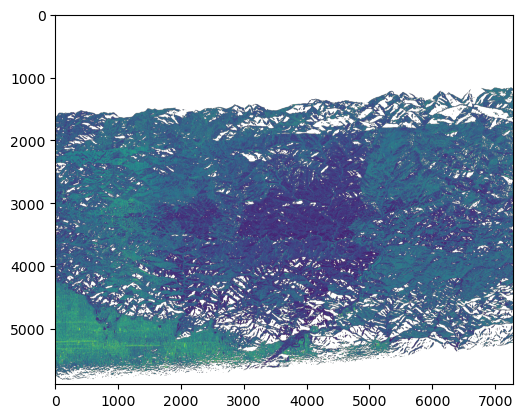

In [22]:
plt.imshow((alpha_south))

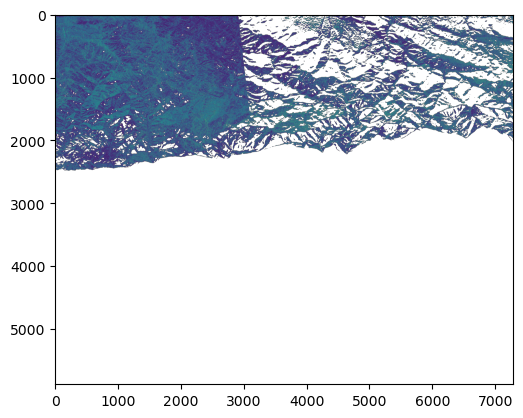

In [23]:
plt.imshow((alpha_north))  

In [24]:
print(alpha_north.shape)

(5881, 7290)


In [25]:
print(alpha_south.shape)

(5881, 7290)


In [26]:
post_alpha_merged = np.nanmax(np.stack([alpha_south, alpha_north]), axis=0)


/tmp/ipykernel_20569/329530378.py:1: RuntimeWarning: All-NaN slice encountered
  post_alpha_merged = np.nanmax(np.stack([alpha_south, alpha_north]), axis=0)


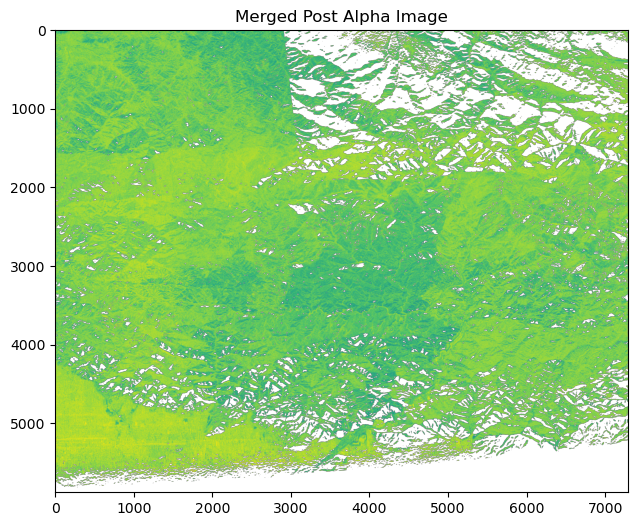

In [27]:
plt.figure(figsize=(10, 6))
plt.title("Merged Post Alpha Image")
plt.imshow(np.log10(post_alpha_merged))
#plt.colorbar(label='log10(backscatter)')
plt.show()
